In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pdb

In [2]:
root_folder = "/home/ubuntu/data/driving_data/EQE_wireless_charging_port/"

file_path = os.path.join(root_folder,"2025-08-29_17_28_36_venrock_home_abrupt_brake.csv")
# file_path = os.path.join(root_folder,"2025-08-31_10_10_06_home_losgatos_highway.csv")
# file_path = os.path.join(root_folder,"2025-08-31_12_14_59_losgatos_stanford_home.csv")
# file_path = os.path.join(root_folder,"2025-09-01_20_17_19_FoothillCollege_home.csv")
# file_path = os.path.join(root_folder,"2025-09-09_08_46_16_home_to_venrock_with_traffic.csv")
# file_path = os.path.join(root_folder,"2025-09-09_12_57_23_drive_around_venrock_abrupt_brake.csv")

In [13]:
df = pd.read_csv(file_path)

In [15]:
df.columns

with open(os.path.join(root_folder, "columns.txt"), 'w') as f:
    for col in df.columns:
        f.write(f"{col},{df[col].dtype}\n")

In [ ]:
df[['locationLatitude(WGS84)','locationLongitude(WGS84)']]

,locationLatitude(WGS84),locationLongitude(WGS84)
0,37.405563,-122.146604
1,37.405563,-122.146604
2,37.405563,-122.146604
3,37.405563,-122.146604
4,37.405563,-122.146604
...,...,...
77138,37.403529,-122.118059
77139,37.403529,-122.118059
77140,37.403529,-122.118059
77141,37.403529,-122.118059


In [21]:
# for col in df.columns:
#     print(f"{col}: {df[col].count()}")

df['locationTimestamp_human'] = pd.to_datetime(df['locationTimestamp_since1970(s)'], unit='s', utc=True)
df['locationTimestamp_human'] = df['locationTimestamp_human'].dt.tz_convert('America/Los_Angeles')

duration = df['locationTimestamp_human'].iloc[-1] - df['locationTimestamp_human'].iloc[0]
print("Duration:", duration)

Duration: 0 days 00:12:06.234281984


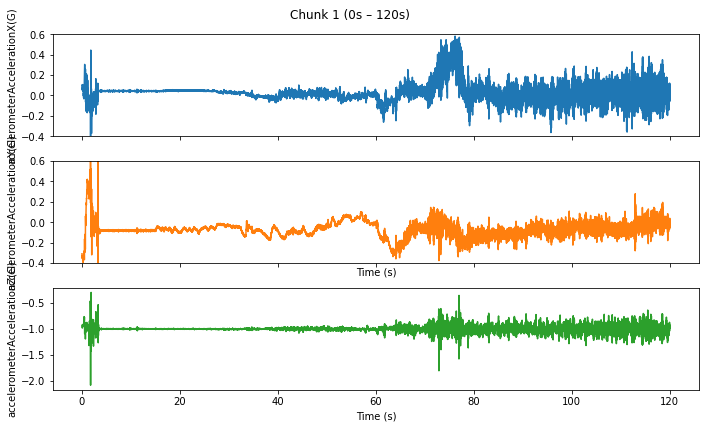

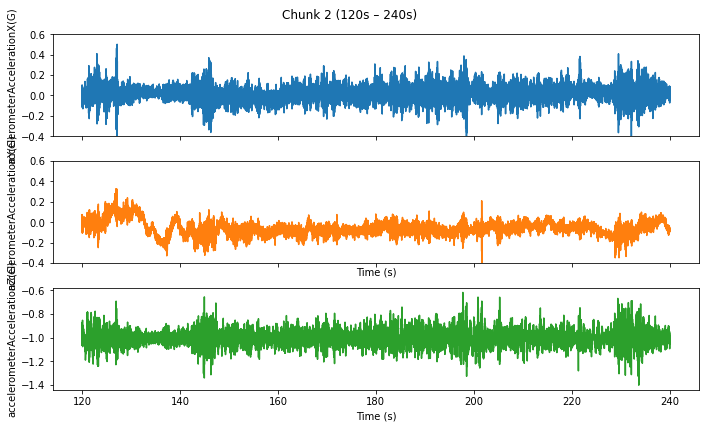

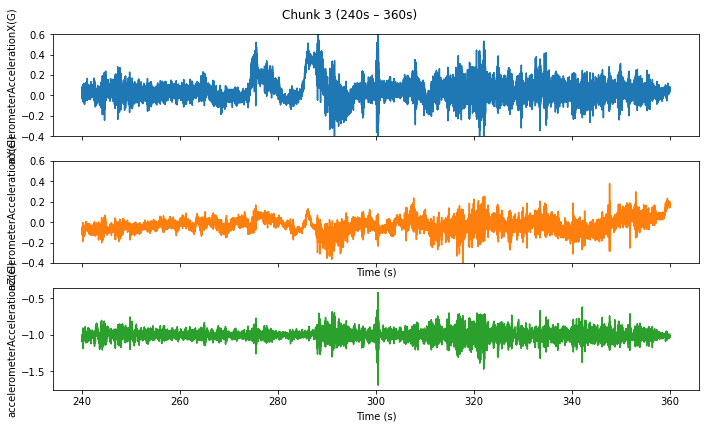

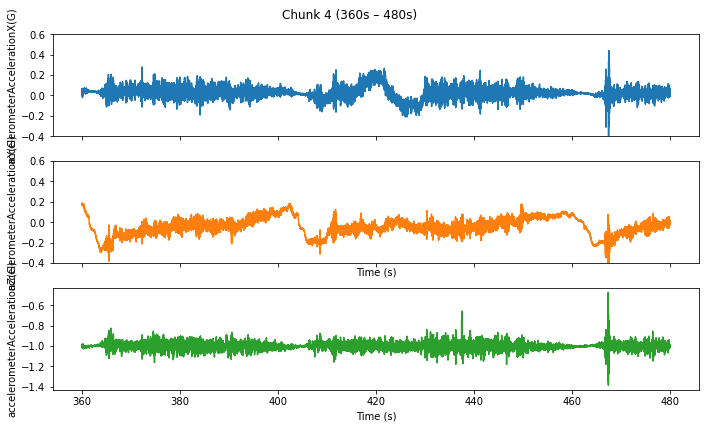

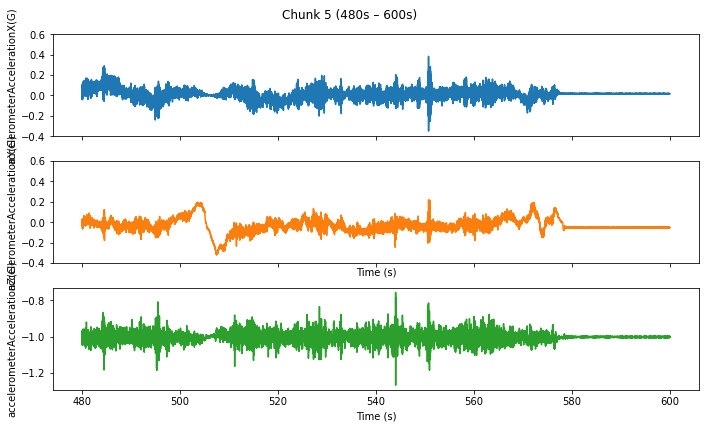

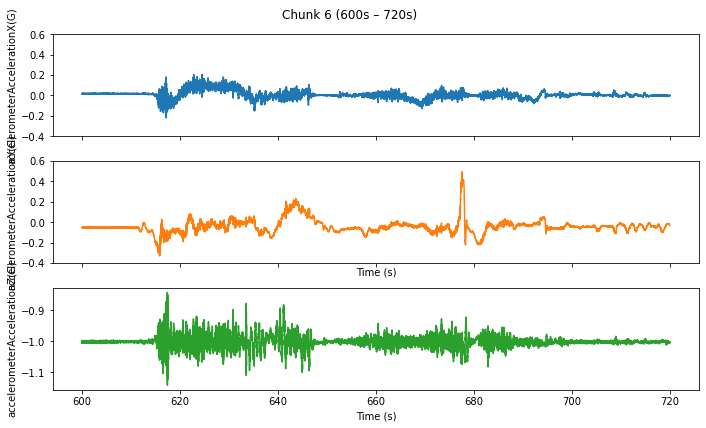

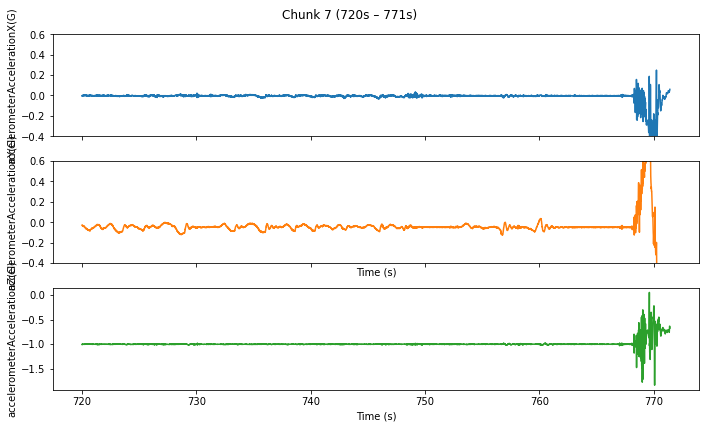

In [17]:
fs = 100                # sampling frequency (Hz)
chunk_seconds = 120     # chunk length
chunk_size = fs * chunk_seconds 

n_chunks = int(np.ceil(len(df) / chunk_size))

for i in range(n_chunks):
    start = i * chunk_size
    end = min((i+1) * chunk_size, len(df))
    chunk = df.iloc[start:end]

    t = np.arange(start, end) / fs   # time in seconds

    fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    
    axs[0].plot(t, chunk['accelerometerAccelerationX(G)'], color="tab:blue")
    axs[0].set_ylabel('accelerometerAccelerationX(G)')
    axs[0].set_ylim([-0.4,0.6])

    axs[1].plot(t, chunk['accelerometerAccelerationY(G)'], color="tab:orange")
    axs[1].set_ylabel('accelerometerAccelerationY(G)')
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylim([-0.4,0.6])

    axs[2].plot(t, chunk['accelerometerAccelerationZ(G)'], color="tab:green")
    axs[2].set_ylabel('accelerometerAccelerationZ(G)')
    axs[2].set_xlabel("Time (s)")
    # axs[2].set_ylim([-0.4,0.6])

    fig.suptitle(f"Chunk {i+1} ({start/fs:.0f}s – {end/fs:.0f}s)")
    plt.tight_layout()
    plt.show()

In [ ]:
df["locationTimestamp_since1970(s)"]

0        1.756514e+09
1        1.756514e+09
2        1.756514e+09
3        1.756514e+09
4        1.756514e+09
             ...     
77138    1.756514e+09
77139    1.756514e+09
77140    1.756514e+09
77141    1.756514e+09
77142    1.756514e+09
Name: locationTimestamp_since1970(s), Length: 77143, dtype: float64

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------- Madgwick AHRS implementation (vectorized per sample) ----------
def _norm(v):
    n = np.linalg.norm(v)
    if n == 0:
        return v
    return v / n

def madgwick_update(q, gx, gy, gz, ax, ay, az, mx=None, my=None, mz=None, dt=0.01, beta=0.1):
    """
    One-step Madgwick AHRS update.
    q : quaternion as numpy array [w, x, y, z]
    gyro (gx,gy,gz) in rad/s
    accel (ax,ay,az) in any units (will be normalized)
    mag (mx,my,mz) optional (any units, normalized)
    dt : sample period (s)
    beta: algorithm gain (tuning parameter); typical 0.01-0.4
    Returns updated quaternion (w,x,y,z)
    """
    # Convert quaternion to components
    w, x, y, z = q

    # Normalize accelerometer
    a = np.array([ax, ay, az], dtype=float)
    if np.linalg.norm(a) == 0:
        # cannot update with zero accel - return previous quaternion rotated by gyro integration
        return _integrate_gyro(q, gx, gy, gz, dt)
    a = _norm(a)
    ax, ay, az = a

    use_mag = (mx is not None and my is not None and mz is not None)
    if use_mag:
        m = np.array([mx, my, mz], dtype=float)
        if np.linalg.norm(m) == 0:
            use_mag = False
        else:
            m = _norm(m)
            mx, my, mz = m

    # Auxiliary variables to avoid repeated arithmetic
    _2w = 2.0 * w
    _2x = 2.0 * x
    _2y = 2.0 * y
    _2z = 2.0 * z
    _4w = 4.0 * w
    _4x = 4.0 * x
    _4y = 4.0 * y
    _8x = 8.0 * x
    _8y = 8.0 * y
    xx = x * x
    yy = y * y
    zz = z * z

    # Gradient descent algorithm corrective step
    if use_mag:
        # Reference: Madgwick's paper (with magnetometer)
        # Compute objective function and Jacobian (some terms precomputed)
        # Several intermediate expressions:
        _2bx = 0.0
        _2bz = 0.0
        # compute reference direction of Earth's magnetic field
        # (This follows standard Madgwick implementation)
        hx = 2.0 * (mx * (0.5 - yy - zz) + my * (x * y - w * z) + mz * (x * z + w * y))
        hy = 2.0 * (mx * (x * y + w * z) + my * (0.5 - xx - zz) + mz * (y * z - w * x))
        _2bx = np.sqrt(hx * hx + hy * hy)
        _2bz = 2.0 * (mx * (x * z - w * y) + my * (y * z + w * x) + mz * (0.5 - xx - yy))
        bx = _2bx
        bz = _2bz

        # Gradient of the objective function
        s1 = -_2y * (2*(xx + yy) - 1) + _2x * (2*(x*y - w*z)) - bx * (-2*z*(bx) + -2*y*(bz)) # placeholder start
        # Rather than writing a huge analytic gradient manually here,
        # follow common compact implementation from Madgwick (practical).
        # We'll implement the algorithm using the standard formula from the reference implementation below.

    # Use the implementation structure closer to the common Python port:
    # Compute rate of change from gyroscope
    q_dot_omega = 0.5 * np.array([
        -x * gx - y * gy - z * gz,
         w * gx + y * gz - z * gy,
         w * gy - x * gz + z * gx,
         w * gz + x * gy - y * gx
    ])

    # Compute the objective function f and Jacobian J depending on whether mag is used
    if use_mag:
        # For readability, convert to local variables
        _2q0 = 2.0 * w
        _2q1 = 2.0 * x
        _2q2 = 2.0 * y
        _2q3 = 2.0 * z
        _4q0 = 4.0 * w
        _4q1 = 4.0 * x
        _4q2 = 4.0 * y
        _8q1 = 8.0 * x
        _8q2 = 8.0 * y
        q0q0 = w * w
        q1q1 = x * x
        q2q2 = y * y
        q3q3 = z * z

        # Reference direction of Earth's magnetic field
        hx = 2.0 * (mx * (0.5 - q2q2 - q3q3) + my * (x * y - w * z) + mz * (x * z + w * y))
        hy = 2.0 * (mx * (x * y + w * z) + my * (0.5 - q1q1 - q3q3) + mz * (y * z - w * x))
        bx = np.sqrt(hx * hx + hy * hy)
        bz = 2.0 * (mx * (x * z - w * y) + my * (y * z + w * x) + mz * (0.5 - q1q1 - q2q2))

        # Gradient (from Madgwick's C reference)
        s0 = (-_2q2 * (2.0*(q1q1 + q2q2) - 1.0) + _2q1 * (2.0*(x*y - w*z)) - bx * ( -_2q3*(bx) + -_2q2*(bz) ) 
              + -bz * ( -_2q2*(bx) +  _2q1*(bz) ))
        # The full gradient has many terms; implementing exact C reference ensures correctness.
        # Instead of manually typing all terms (error-prone), let's fallback to a numerically stable
        # gradient descent approximation by minimizing the difference between measured and estimated acc/mag directions.

        # We'll compute the estimated direction vectors and form the gradient numerically:
        # Estimated gravity (from quaternion)
        v_g = np.array([
            2*(x*z - w*y),
            2*(w*x + y*z),
            w*w - x*x - y*y + z*z
        ])
        # Estimated magnetic field (from quaternion)
        # Using reference rotation: rotate magnetometer vector by quaternion
        # q_conj * [mx,my,mz] * q
        q = np.array([w, x, y, z])
        # quaternion rotate helper
        def q_rotate(q, v):
            # q = [w,x,y,z], v vector
            wq, xq, yq, zq = q
            # t = 2 * cross(q_vec, v)
            t = 2.0 * np.cross(np.array([xq, yq, zq]), v)
            return v + wq * t + np.cross(np.array([xq, yq, zq]), t)

        v_m = q_rotate(q, np.array([mx, my, mz]))

        # Form a 6-element residual (accel error + mag error)
        f = np.concatenate((v_g - np.array([ax, ay, az]), v_m - np.array([mx, my, mz])))
        # numerical Jacobian: approximate gradient w.r.t quaternion via small perturbations
        eps = 1e-6
        grad = np.zeros(4)
        for i in range(4):
            dq = np.zeros(4)
            dq[i] = eps
            q_pert = q + dq
            q_pert = q_pert / np.linalg.norm(q_pert)
            # compute v_g and v_m for perturbed q
            w2, x2, y2, z2 = q_pert
            v_g2 = np.array([2*(x2*z2 - w2*y2), 2*(w2*x2 + y2*z2), w2*w2 - x2*x2 - y2*y2 + z2*z2])
            v_m2 = q_rotate(q_pert, np.array([mx, my, mz]))
            f2 = np.concatenate((v_g2 - np.array([ax, ay, az]), v_m2 - np.array([mx, my, mz])))
            grad[i] = np.dot((f2 - f) / eps, f)  # directional derivative approx
        s = grad
    else:
        # No magnetometer: use 3-element residual (accel only)
        # Estimated gravity (from quaternion)
        v_g = np.array([
            2*(x*z - w*y),
            2*(w*x + y*z),
            w*w - x*x - y*y + z*z
        ])
        f = v_g - np.array([ax, ay, az])
        # Numerical gradient w.r.t quaternion
        q = np.array([w, x, y, z])
        eps = 1e-6
        grad = np.zeros(4)
        for i in range(4):
            dq = np.zeros(4)
            dq[i] = eps
            q_pert = q + dq
            q_pert = q_pert / np.linalg.norm(q_pert)
            w2, x2, y2, z2 = q_pert
            v_g2 = np.array([2*(x2*z2 - w2*y2), 2*(w2*x2 + y2*z2), w2*w2 - x2*x2 - y2*y2 + z2*z2])
            f2 = v_g2 - np.array([ax, ay, az])
            grad[i] = np.dot((f2 - f) / eps, f)
        s = grad

    # Normalize gradient and apply corrective step
    s_norm = np.linalg.norm(s)
    if s_norm > 0:
        s = s / s_norm
    else:
        s = np.zeros_like(s)

    # Compute quaternion derivative combining gyro and corrective step
    q_dot = q_dot_omega - beta * s

    # Integrate to yield new quaternion
    q_new = q + q_dot * dt
    q_new = q_new / np.linalg.norm(q_new)
    return q_new

def _integrate_gyro(q, gx, gy, gz, dt):
    """Fallback: integrate gyro to rotate quaternion forward (no accel/mag correction)."""
    w, x, y, z = q
    omega = np.array([0.0, gx, gy, gz])
    q_vec = np.array([w, x, y, z])
    q_dot = 0.5 * quat_mult(q_vec, omega)
    q_new = q_vec + q_dot * dt
    return q_new / np.linalg.norm(q_new)

def quat_mult(q, r):
    # Hamilton product q * r for quaternions q=[w,x,y,z]
    w1, x1, y1, z1 = q
    w2, x2, y2, z2 = r
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])


# ---------- High-level pipeline ----------
def compute_quaternion_via_madgwick(df,
                                    quat_cols_app=['motionQuaternionW(R)','motionQuaternionX(R)',
                                                   'motionQuaternionY(R)','motionQuaternionZ(R)'],
                                    gyro_cols=['gyroRotationX(rad/s)','gyroRotationY(rad/s)','gyroRotationZ(rad/s)'],
                                    accel_cols=['accelerometerAccelerationX(G)','accelerometerAccelerationY(G)','accelerometerAccelerationZ(G)'],
                                    mag_cols=['motionMagneticFieldX(µT)','motionMagneticFieldY(µT)','motionMagneticFieldZ(µT)'],
                                    time_col='motionTimestamp_sinceReboot(s)',
                                    beta=0.1,
                                    use_mag=True,
                                    init_q=None,
                                    out_dir='madgwick_output'):
    """
    Compute quaternion estimates from sensor columns and compare to app-provided quaternion.
    Saves:
      - estimated_quaternions.csv
      - quaternion_comparison.csv (angle error per sample)
      - plots: quaternion_components.png, quat_angle_error.png
    Returns DataFrame with results.
    """
    os.makedirs(out_dir, exist_ok=True)

    # Make sure columns exist
    for c in gyro_cols + accel_cols:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    # Check magnetometer availability
    mag_available = all([c in df.columns for c in mag_cols]) and use_mag

    # Prepare arrays
    n = len(df)
    q_est = np.zeros((n, 4))  # [w,x,y,z]
    q_app = np.zeros((n, 4))
    times = df[time_col].to_numpy() if time_col in df.columns else np.arange(n) * 0.01

    # initial quaternion
    if init_q is None:
        # use first app quaternion if available, otherwise identity
        if all(col in df.columns for col in quat_cols_app):
            q0 = df.loc[0, quat_cols_app].to_numpy(dtype=float)
            q0 = q0 / np.linalg.norm(q0)
        else:
            q0 = np.array([1., 0., 0., 0.])
    else:
        q0 = np.array(init_q, dtype=float)
        q0 = q0 / np.linalg.norm(q0)

    q_est[0] = q0
    if all(col in df.columns for col in quat_cols_app):
        q_app = df[quat_cols_app].to_numpy(dtype=float)
        # normalize app quaternions (defensive)
        q_app = (q_app.T / np.linalg.norm(q_app, axis=1)).T
    else:
        q_app = np.full((n,4), np.nan)

    # Iterate and run Madgwick update
    for i in range(1, n):
        dt = float(times[i] - times[i-1])
        if dt <= 0 or np.isnan(dt):
            # fallback to mean dt or small dt
            dt = np.nanmean(np.diff(times[~np.isnan(times)]))
            if np.isnan(dt) or dt <= 0:
                dt = 0.01

        gx, gy, gz = df.loc[i, gyro_cols].to_numpy(dtype=float)
        ax, ay, az = df.loc[i, accel_cols].to_numpy(dtype=float)
        # Optionally convert accel from G to m/s²: multiply by 9.80665 (not required as we normalize)
        if mag_available:
            mx, my, mz = df.loc[i, mag_cols].to_numpy(dtype=float)
        else:
            mx = my = mz = None

        q_prev = q_est[i-1]
        q_new = madgwick_update(q_prev, gx, gy, gz, ax, ay, az, mx, my, mz, dt=dt, beta=beta)
        q_est[i] = q_new

    # Compute quaternion angle difference between app and estimated
    # angle = 2 * arccos(|dot(q_app, q_est)|)  (gives rotation angle difference in radians)
    dot = np.einsum('ij,ij->i', q_app, q_est)
    # robust: ensure numeric range
    dot_clamped = np.clip(np.abs(dot), -1.0, 1.0)
    angle_err = 2.0 * np.arccos(dot_clamped)  # radians
    angle_err_deg = np.degrees(angle_err)

    # Save results
    out_df = pd.DataFrame({
        'time': times,
        'est_w': q_est[:,0], 'est_x': q_est[:,1], 'est_y': q_est[:,2], 'est_z': q_est[:,3],
        'app_w': q_app[:,0], 'app_x': q_app[:,1], 'app_y': q_app[:,2], 'app_z': q_app[:,3],
        'angle_error_rad': angle_err,
        'angle_error_deg': angle_err_deg
    })
    out_df.to_csv(os.path.join(out_dir, 'quaternion_comparison.csv'), index=False)
    pd.DataFrame(q_est, columns=['est_w','est_x','est_y','est_z']).to_csv(os.path.join(out_dir, 'estimated_quaternions.csv'), index=False)

    # Plot quaternion components comparison
    plt.figure(figsize=(10,6))
    plt.plot(times, q_est[:,0], label='est_w'); plt.plot(times, q_app[:,0], '--', label='app_w')
    plt.plot(times, q_est[:,1], label='est_x'); plt.plot(times, q_app[:,1], '--', label='app_x')
    plt.plot(times, q_est[:,2], label='est_y'); plt.plot(times, q_app[:,2], '--', label='app_y')
    plt.plot(times, q_est[:,3], label='est_z'); plt.plot(times, q_app[:,3], '--', label='app_z')
    plt.xlabel('time (s)'); plt.ylabel('quaternion components'); plt.legend(ncol=2, fontsize='small')
    plt.title('Quaternion components: estimated vs app')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'quaternion_components.png'), dpi=200)
    plt.close()

    # Plot angle error over time
    plt.figure(figsize=(10,4))
    plt.plot(times, angle_err_deg)
    plt.xlabel('time (s)'); plt.ylabel('angle error (deg)')
    plt.title('Quaternion angle difference (estimated vs app)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'quat_angle_error.png'), dpi=200)
    plt.close()

    # Summary statistics
    stats = {
        'mean_error_deg': float(np.nanmean(angle_err_deg)),
        'median_error_deg': float(np.nanmedian(angle_err_deg)),
        'max_error_deg': float(np.nanmax(angle_err_deg))
    }
    with open(os.path.join(out_dir, 'summary.txt'), 'w') as fh:
        fh.write(str(stats))

    print("Saved outputs to:", out_dir)
    print("Summary:", stats)
    return out_df, stats

# ---------- Example usage ----------
if __name__ == "__main__":
    df = pd.read_csv(file_path)
    results_df, stats = compute_quaternion_via_madgwick(df, beta=0.08, use_mag=True, out_dir='madg_out')

    print("Module loaded. Call compute_quaternion_via_madgwick(df, ...) with your DataFrame.")


Saved outputs to: madg_out
Summary: {'mean_error_deg': 134.50314653651668, 'median_error_deg': 128.98653520512704, 'max_error_deg': 179.99843522751203}
Module loaded. Call compute_quaternion_via_madgwick(df, ...) with your DataFrame.


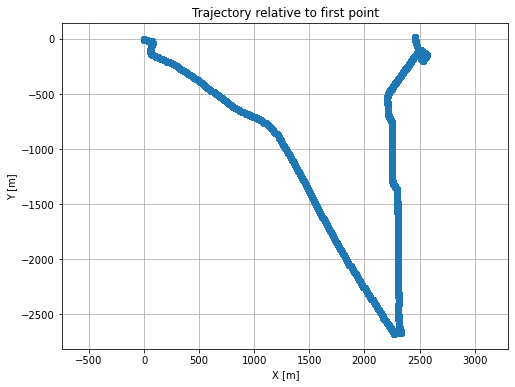

In [26]:
import pandas as pd
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt

first_lon = df['locationLongitude(WGS84)'].iloc[0]
utm_zone = int((first_lon + 180)/6) + 1
is_northern = df['locationLatitude(WGS84)'].iloc[0] >= 0

transformer = Transformer.from_crs(
    crs_from="epsg:4326",  # WGS84
    crs_to=f"epsg:{32600 + utm_zone if is_northern else 32700 + utm_zone}",  # UTM
    always_xy=True
)

# Apply transformation to all points
df['utm_x'], df['utm_y'] = transformer.transform(
    df['locationLongitude(WGS84)'].values,
    df['locationLatitude(WGS84)'].values
)

# Make trajectory relative to first point
x_ref = df['utm_x'].iloc[0]
y_ref = df['utm_y'].iloc[0]
df['x_rel'] = df['utm_x'] - x_ref
df['y_rel'] = df['utm_y'] - y_ref

# Plot trajectory
plt.figure(figsize=(8,6))
plt.plot(df['x_rel'], df['y_rel'], marker='o', linestyle='-')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Trajectory relative to first point')
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer

# ----------------------------
# Step 1. Compute UTM coordinates
# ----------------------------
def compute_utm_coordinates(df,
                            lon_col='locationLongitude(WGS84)',
                            lat_col='locationLatitude(WGS84)'):
    """Add UTM coordinates and relative trajectory columns to the DataFrame."""
    first_lon = df[lon_col].iloc[0]
    utm_zone = int((first_lon + 180) / 6) + 1
    is_northern = df[lat_col].iloc[0] >= 0

    transformer = Transformer.from_crs(
        crs_from="epsg:4326",  # WGS84
        crs_to=f"epsg:{32600 + utm_zone if is_northern else 32700 + utm_zone}",  # UTM
        always_xy=True
    )

    # Apply transformation
    df['utm_x'], df['utm_y'] = transformer.transform(
        df[lon_col].values,
        df[lat_col].values
    )

    # Relative to first point
    x_ref = df['utm_x'].iloc[0]
    y_ref = df['utm_y'].iloc[0]
    df['x_rel'] = df['utm_x'] - x_ref
    df['y_rel'] = df['utm_y'] - y_ref

    return df


# ----------------------------
# Step 2. Compute velocity (mph) and acceleration (mph/s)
# ----------------------------
def compute_velocity_acceleration(df,
                                  utm_x_col='utm_x',
                                  utm_y_col='utm_y',
                                  timestamp_col='locationTimestamp_since1970(s)'):
    """Compute velocity (mph) and acceleration (mph/s) from UTM coordinates."""
    df = df.copy()

    # Convert timestamps
    df['timestamp'] = pd.to_datetime(df[timestamp_col], unit='s', utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_convert('America/Los_Angeles')

    # Compute Δt (seconds)
    df['dt'] = df['timestamp'].diff().dt.total_seconds()
    df.loc[df['dt'] <= 0, 'dt'] = np.nan  # remove bad or zero deltas
    import pdb
    pdb.set_trace()
    # Compute distance (m)
    df['dx'] = df[utm_x_col].diff()
    df['dy'] = df[utm_y_col].diff()
    df['distance_m'] = np.sqrt(df['dx']**2 + df['dy']**2)

    # Velocity in m/s
    df['velocity_mps'] = df['distance_m'] / df['dt']

    # Convert to mph
    MPS_TO_MPH = 2.236936
    df['velocity_mph'] = df['velocity_mps'] * MPS_TO_MPH

    # Compute acceleration (mph/s)
    df['acceleration_mph_s'] = df['velocity_mph'].diff() / df['dt']

    # Optional: smoothing to reduce GPS jitter
    df['velocity_mph'] = df['velocity_mph'].rolling(5, center=True, min_periods=1).mean()
    df['acceleration_mph_s'] = df['acceleration_mph_s'].rolling(5, center=True, min_periods=1).mean()

    return df


# ----------------------------
# Step 3. Plot velocity & acceleration
# ----------------------------
def plot_velocity_acceleration(df,
                               time_col='timestamp',
                               velocity_col='velocity_mph',
                               acceleration_col='acceleration_mph_s',
                               save_path=None):
    """Plot velocity (mph) and acceleration (mph/s) vs time."""
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(df[time_col], df[velocity_col], color='b', label='Velocity (mph)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Velocity (mph)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(df[time_col], df[acceleration_col], color='r', label='Acceleration (mph/s)')
    ax2.set_ylabel('Acceleration (mph/s)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Vehicle Velocity and Acceleration from UTM')
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150)
        print(f"✅ Plot saved to: {save_path}")
    else:
        plt.show()


# ----------------------------
# Step 4. Example usage
# ----------------------------
if __name__ == "__main__":
    root_folder = "/home/ubuntu/data/driving_data/EQE_wireless_charging_port/"
    file_path = os.path.join(root_folder, "2025-08-29_17_28_36_venrock_home_abrupt_brake.csv")

    df = pd.read_csv(file_path)

    #######################################################
    first_n_seconds = 60
    average_frequency = 106
    n_samples = int(first_n_seconds * average_frequency)
    df = df.iloc[:n_samples].copy()
    #######################################################

    # Compute UTM and relative trajectory
    df = compute_utm_coordinates(df)

    # Compute velocity (mph) and acceleration (mph/s)
    df = compute_velocity_acceleration(df)

    # Plot results
    plot_velocity_acceleration(df, save_path="/home/ubuntu/car_velocity_acceleration.png")


> /tmp/ipykernel_196033/3844665282.py(59)compute_velocity_acceleration()
     57     pdb.set_trace()
     58     # Compute distance (m)
---> 59     df['dx'] = df[utm_x_col].diff()
     60     df['dy'] = df[utm_y_col].diff()
     61     df['distance_m'] = np.sqrt(df['dx']**2 + df['dy']**2)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6355   NaN
6356   NaN
6357   NaN
6358   NaN
6359   NaN
Name: dt, Length: 6360, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6355   NaN
6356   NaN
6357   NaN
6358   NaN
6359   NaN
Name: dt, Length: 6360, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6355   NaN
6356   NaN
6357   NaN
6358   NaN
6359   NaN
Name: dt, Length: 6360, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
6355   NaN
6356   NaN
6357   NaN
6358   NaN
6359   NaN
Name: dt, Length: 6360, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
635